# Combining the dataset and Modeling

<img src="All_Articles.jpg">

In [1]:
import pandas as pd
from collections import Counter
import re
import numpy as np
from random import randint
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import f1_score, accuracy_score , recall_score , precision_score
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from __future__ import division

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\Aditya Goel\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Reading NYT dataset
# df_nyt = pd.read_csv("/Users/Yemre/Desktop/News_Data_Mix/NYT_Combined_Clean_APR_4_No_Slash.csv")

In [3]:
# Adding label to real news to the dataset and showing the column names
# df_nyt["fakeness"] = 0
# df_nyt.columns

In [4]:
# Reading The Guardian dataset
df_tguard = pd.read_csv("C:/Users/Aditya Goel/Documents/Minor Project/Detecting_Fake_News-master/Modeling_and_Grid_Search/CleanData/Clean_TheGuardian_Combined_No_Slash.csv")

In [5]:
# Adding label to real news to the dataset and showing the column names
df_tguard["fakeness"] = 0
df_tguard.columns

Index(['Unnamed: 0', 'apiUrl', 'fields', 'id', 'isHosted', 'sectionId',
       'sectionName', 'type', 'webPublicationDate', 'webTitle', 'webUrl',
       'bodyText', 'headline', 'fakeness'],
      dtype='object')

In [6]:
df_fake = pd.read_csv("C:/Users/Aditya Goel/Documents/Minor Project/Detecting_Fake_News-master/Modeling_and_Grid_Search/CleanData/FakeNews_Clean_All.csv")

In [7]:
# Label was there for fake news dataset and showing the column names
df_fake.columns

Index(['Unnamed: 0', 'uuid', 'ord_in_thread', 'published', 'title', 'text',
       'language', 'crawled', 'site_url', 'country', 'thread_title',
       'spam_score', 'replies_count', 'participants_count', 'likes',
       'comments', 'shares', 'type', 'fakeness'],
      dtype='object')

In [8]:
# Changing the name of the column for concating later
df_tguard = df_tguard.rename(columns={'bodyText' : 'body','webPublicationDate':'pub_date'})
#df_nyt = df_nyt.rename(columns={'head_clean':'headline','_id':'id'})
df_fake = df_fake.rename(columns={'text':'body','title':'headline','uuid':'id','published':'pub_date'})
df_fake.columns,df_tguard.columns

(Index(['Unnamed: 0', 'id', 'ord_in_thread', 'pub_date', 'headline', 'body',
        'language', 'crawled', 'site_url', 'country', 'thread_title',
        'spam_score', 'replies_count', 'participants_count', 'likes',
        'comments', 'shares', 'type', 'fakeness'],
       dtype='object'),
 Index(['Unnamed: 0', 'apiUrl', 'fields', 'id', 'isHosted', 'sectionId',
        'sectionName', 'type', 'pub_date', 'webTitle', 'webUrl', 'body',
        'headline', 'fakeness'],
       dtype='object'))

In [9]:
# Dropping unnecesary columns
df_fake.drop([u'Unnamed: 0', u'ord_in_thread', 
         u'language', u'crawled', u'site_url', u'country',
        u'thread_title', u'spam_score', u'replies_count', u'participants_count',
        u'likes', u'comments', u'shares', u'type'],inplace=True,axis=1)

df_tguard.drop([u'Unnamed: 0', u'apiUrl', u'fields', 
        u'isHosted', u'sectionId', u'sectionName', u'type',
         u'webTitle', u'webUrl'],inplace=True,axis=1)

In [10]:
# Overview for data
df_fake.head()

,id,pub_date,headline,body,fakeness
0,6a175f46bcd24d39b3e962ad0f29936721db70db,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Govt Be...,Print They should pay all the back all the mon...,1
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,1
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,1
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,1
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,1


In [11]:
# Overview for data
# df_nyt.head()

In [12]:
# Overview for data
df_tguard.head()

,id,pub_date,body,headline,fakeness
0,business/2016/may/02/english-businesses-should...,2016-05-01T23:01:08Z,All premises in England that sell food should ...,English businesses 'should be forced to show h...,0
1,business/2016/may/02/tips-should-go-to-workers...,2016-05-01T23:01:07Z,"Tips in restaurants, hotels and bars should go...","Tips should go to workers, not employers, says...",0
2,politics/blog/live/2016/may/01/scottish-electi...,2016-05-01T21:51:50Z,Election debates are more common in Holyrood p...,Sturgeon accused of breaking independence prom...,0
3,politics/2016/may/01/scottish-independence-vot...,2016-05-01T21:40:37Z,Nicola Sturgeon has said a second independence...,Second Scottish independence vote not yet on t...,0
4,us-news/2016/may/01/bernie-sanders-contested-c...,2016-05-01T21:16:57Z,Bernie Sanders acknowledged “an uphill climb” ...,Bernie Sanders vows a contested convention des...,0


In [13]:
# Concat the datasents
df_all = df_fake.append(df_tguard, ignore_index=True)
# df_all = df_all.append(df_nyt,ignore_index=True)

In [14]:
#Dropping the Nan values and info
df_all.dropna(inplace=True)
print (df_all.shape)
df_all.info()

(20729, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20729 entries, 0 to 20729
Data columns (total 5 columns):
body        20729 non-null object
fakeness    20729 non-null int64
headline    20729 non-null object
id          20729 non-null object
pub_date    20729 non-null object
dtypes: int64(1), object(4)
memory usage: 971.7+ KB


In [15]:
df_all['source_id'] = np.random.randint(1, 1000, df_all.shape[0])
df_all['likes'] = np.random.randint(1, 10000, df_all.shape[0])
df_all['dislikes'] = np.random.randint(1, 10000, df_all.shape[0])
df_all['user_reliability'] = 0
df_all['user_controversiality'] = 0
df_all.head()

,body,fakeness,headline,id,pub_date,source_id,likes,dislikes,user_reliability,user_controversiality
0,Print They should pay all the back all the mon...,1,Muslims BUSTED: They Stole Millions In Govt Be...,6a175f46bcd24d39b3e962ad0f29936721db70db,2016-10-26T21:41:00.000+03:00,340,5431,134,0,0
1,Why Did Attorney General Loretta Lynch Plead T...,1,Re: Why Did Attorney General Loretta Lynch Ple...,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,2016-10-29T08:47:11.259+03:00,939,8321,7787,0,0
2,Red State : \nFox News Sunday reported this mo...,1,BREAKING: Weiner Cooperating With FBI On Hilla...,c70e149fdd53de5e61c29281100b9de0ed268bc3,2016-10-31T01:41:49.479+02:00,272,4913,3140,0,0
3,Email Kayla Mueller was a prisoner and torture...,1,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,7cf7c15731ac2a116dd7f629bd57ea468ed70284,2016-11-01T05:22:00.000+02:00,762,1028,4698,0,0
4,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,1,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,0206b54719c7e241ffe0ad4315b808290dbe6c0f,2016-11-01T21:56:00.000+02:00,777,2500,2737,0,0


In [16]:
#Calculate user controversiality as pow((p + q), (min(p/q, q/p) - 1))

df_all.user_controversiality = df_all.user_controversiality.astype(float)
for index, row in df_all.iterrows():
        df_all.set_value(index, 'user_controversiality', (row['likes'] + row['dislikes']) ** min(row['dislikes'] / float(row['likes']) - 1, row['likes'] / float(row['dislikes']) - 1))

print(df_all['user_controversiality'])


0        0.000222
1        0.537048
2        0.038942
3        0.001160
4        0.476387
5        0.482474
6        0.037993
7        0.115318
8        0.117410
9        0.926047
10       0.001347
11       0.010495
12       0.014060
13       0.003043
14       0.001956
15       0.224117
16       0.180444
17       0.002380
18       0.033405
19       0.000816
20       0.001216
21       0.001969
22       0.000441
23       0.004864
24       0.579447
25       0.000321
26       0.001263
27       0.217154
28       0.000998
29       0.000296
           ...   
20700    0.234898
20701    0.874555
20702    0.000907
20703    0.357741
20704    0.074264
20705    0.000164
20706    0.044830
20707    0.000506
20708    0.000495
20709    0.225300
20710    0.015925
20711    0.426805
20712    0.092943
20713    0.043939
20714    0.243237
20715    0.000641
20716    0.089395
20717    0.339784
20718    0.003199
20719    0.577050
20720    0.070785
20721    0.204994
20722    0.016900
20723    0.361180
20724    0

In [17]:
x4 = df_all.groupby(['source_id', 'fakeness']).size()
df_all.user_reliability = df_all.user_reliability.astype(float)
for index, row in df_all.iterrows():
        print(x4[row['source_id']][0] / float(x4[row['source_id']][0] + x4[row['source_id']][1] + 0.0))
#         print (x4[row['source_id']][0], x4[row['source_id']][0] + x4[row['source_id']][1])
        df_all.set_value(index, 'user_reliability', x4[row['source_id']][0] / float(x4[row['source_id']][0] + x4[row['source_id']][1] + 0.0))
#         print(row['user_reliability'])

df_all['user_reliability']

0.607142857143
0.24
0.5
0.333333333333
0.421052631579
0.384615384615
0.333333333333
0.333333333333
0.275862068966
0.45
0.368421052632
0.185185185185
0.4
0.357142857143
0.352941176471
0.380952380952
0.421052631579
0.272727272727
0.516129032258
0.380952380952
0.307692307692
0.48
0.421052631579
0.424242424242
0.47619047619
0.263157894737
0.55
0.428571428571
0.545454545455
0.5
0.46875
0.35
0.333333333333
0.269230769231
0.333333333333
0.333333333333
0.37037037037
0.52
0.333333333333
0.238095238095
0.333333333333
0.6
0.333333333333
0.258064516129
0.36
0.5
0.454545454545
0.392857142857
0.4
0.6
0.333333333333
0.5
0.466666666667
0.428571428571
0.388888888889
0.47619047619
0.473684210526
0.428571428571
0.535714285714
0.375
0.730769230769
0.296296296296
0.318181818182
0.3125
0.413793103448
0.318181818182
0.407407407407
0.333333333333
0.470588235294
0.307692307692
0.36
0.538461538462
0.434782608696
0.458333333333
0.72
0.55
0.25
0.2
0.346153846154
0.3
0.555555555556
0.518518518519
0.294117647059
0.

0.291666666667
0.526315789474
0.545454545455
0.352941176471
0.3125
0.413793103448
0.416666666667
0.238095238095
0.37037037037
0.380952380952
0.413793103448
0.290322580645
0.318181818182
0.333333333333
0.5
0.45
0.375
0.391304347826
0.52380952381
0.4
0.48275862069
0.5
0.380952380952
0.36
0.380952380952
0.533333333333
0.3125
0.333333333333
0.3
0.352941176471
0.413793103448
0.333333333333
0.368421052632
0.45
0.421052631579
0.684210526316
0.5
0.473684210526
0.388888888889
0.434782608696
0.391304347826
0.571428571429
0.24
0.2
0.333333333333
0.705882352941
0.5
0.5
0.681818181818
0.277777777778
0.533333333333
0.45
0.4
0.5
0.48
0.4
0.473684210526
0.413793103448
0.4
0.416666666667
0.333333333333
0.416666666667
0.5
0.5
0.454545454545
0.421052631579
0.263157894737
0.526315789474
0.5
0.5
0.5
0.56
0.318181818182
0.52380952381
0.307692307692
0.434782608696
0.5
0.388888888889
0.25
0.458333333333
0.4375
0.35
0.55
0.36
0.277777777778
0.48275862069
0.333333333333
0.470588235294
0.538461538462
0.529411764

0.263157894737
0.521739130435
0.4
0.428571428571
0.481481481481
0.428571428571
0.454545454545
0.272727272727
0.45
0.5625
0.478260869565
0.347826086957
0.333333333333
0.666666666667
0.318181818182
0.448275862069
0.5
0.352941176471
0.318181818182
0.304347826087
0.518518518519
0.413793103448
0.576923076923
0.3125
0.444444444444
0.538461538462
0.333333333333
0.529411764706
0.380952380952
0.36
0.619047619048
0.421052631579
0.272727272727
0.5
0.333333333333
0.352941176471
0.296296296296
0.285714285714
0.444444444444
0.454545454545
0.466666666667
0.521739130435
0.35
0.375
0.421052631579
0.333333333333
0.45
0.388888888889
0.458333333333
0.5
0.363636363636
0.363636363636
0.384615384615
0.238095238095
0.529411764706
0.5
0.473684210526
0.411764705882
0.363636363636
0.583333333333
0.318181818182
0.263157894737
0.388888888889
0.321428571429
0.4
0.380952380952
0.428571428571
0.4
0.3125
0.333333333333
0.473684210526
0.2
0.444444444444
0.473684210526
0.5
0.294117647059
0.424242424242
0.363636363636
0.

0.333333333333
0.36
0.55
0.388888888889
0.444444444444
0.37037037037
0.454545454545
0.5625
0.416666666667
0.4
0.363636363636
0.3
0.35
0.5
0.424242424242
0.35
0.318181818182
0.428571428571
0.384615384615
0.333333333333
0.333333333333
0.28
0.35
0.315789473684
0.296296296296
0.380952380952
0.291666666667
0.294117647059
0.555555555556
0.607142857143
0.6
0.3125
0.444444444444
0.3
0.423076923077
0.238095238095
0.416666666667
0.382352941176
0.391304347826
0.5
0.392857142857
0.5
0.392857142857
0.545454545455
0.4
0.3125
0.458333333333
0.428571428571
0.428571428571
0.421052631579
0.444444444444
0.354838709677
0.48
0.45
0.5
0.5
0.5
0.454545454545
0.368421052632
0.379310344828
0.538461538462
0.458333333333
0.37037037037
0.4
0.357142857143
0.2
0.238095238095
0.3
0.5
0.466666666667
0.3125
0.470588235294
0.3125
0.357142857143
0.473684210526
0.3
0.173913043478
0.4
0.518518518519
0.55
0.391304347826
0.375
0.608695652174
0.464285714286
0.5
0.458333333333
0.3
0.37037037037
0.52
0.375
0.382352941176
0.2
0

0.185185185185
0.529411764706
0.411764705882
0.413793103448
0.333333333333
0.413793103448
0.411764705882
0.368421052632
0.25
0.454545454545
0.4375
0.388888888889
0.444444444444
0.428571428571
0.375
0.538461538462
0.45
0.380952380952
0.458333333333
0.421052631579
0.52380952381
0.4
0.318181818182
0.681818181818
0.409090909091
0.166666666667
0.444444444444
0.3125
0.521739130435
0.375
0.380952380952
0.347826086957
0.411764705882
0.32
0.5
0.238095238095
0.272727272727
0.3
0.555555555556
0.533333333333
0.44
0.461538461538
0.3125
0.45
0.2
0.470588235294
0.2
0.375
0.411764705882
0.535714285714
0.333333333333
0.444444444444
0.3
0.294117647059
0.5
0.333333333333
0.307692307692
0.5
0.28
0.1875
0.55
0.571428571429
0.391304347826
0.28
0.458333333333
0.421052631579
0.333333333333
0.521739130435
0.428571428571
0.263157894737
0.521739130435
0.36
0.235294117647
0.45
0.52380952381
0.291666666667
0.5
0.44
0.36
0.235294117647
0.466666666667
0.4
0.571428571429
0.652173913043
0.347826086957
0.421052631579
0

0.464285714286
0.428571428571
0.366666666667
0.4
0.545454545455
0.363636363636
0.37037037037
0.25
0.411764705882
0.388888888889
0.266666666667
0.333333333333
0.275862068966
0.5
0.448275862069
0.454545454545
0.454545454545
0.5
0.375
0.466666666667
0.478260869565
0.433333333333
0.466666666667
0.4
0.466666666667
0.263157894737
0.5
0.615384615385
0.444444444444
0.352941176471
0.391304347826
0.230769230769
0.666666666667
0.379310344828
0.555555555556
0.538461538462
0.428571428571
0.375
0.321428571429
0.411764705882
0.24
0.444444444444
0.363636363636
0.380952380952
0.428571428571
0.375
0.368421052632
0.411764705882
0.647058823529
0.461538461538
0.411764705882
0.235294117647
0.444444444444
0.52
0.461538461538
0.0909090909091
0.380952380952
0.36
0.263157894737
0.315789473684
0.52380952381
0.304347826087
0.529411764706
0.333333333333
0.56
0.5
0.428571428571
0.368421052632
0.321428571429
0.576923076923
0.190476190476
0.428571428571
0.409090909091
0.55
0.5
0.307692307692
0.545454545455
0.68181818

0.428571428571
0.277777777778
0.466666666667
0.45
0.458333333333
0.48
0.266666666667
0.444444444444
0.4
0.380952380952
0.363636363636
0.461538461538
0.266666666667
0.470588235294
0.458333333333
0.5
0.5
0.538461538462
0.380952380952
0.3
0.333333333333
0.347826086957
0.409090909091
0.315789473684
0.380952380952
0.4
0.35
0.6
0.529411764706
0.379310344828
0.565217391304
0.363636363636
0.24
0.375
0.388888888889
0.421052631579
0.314285714286
0.518518518519
0.36
0.366666666667
0.4375
0.4375
0.521739130435
0.470588235294
0.466666666667
0.3
0.52380952381
0.37037037037
0.214285714286
0.333333333333
0.210526315789
0.684210526316
0.478260869565
0.368421052632
0.307692307692
0.681818181818
0.347826086957
0.44
0.388888888889
0.5
0.32
0.272727272727
0.333333333333
0.458333333333
0.48
0.375
0.380952380952
0.333333333333
0.666666666667
0.44
0.357142857143
0.55
0.391304347826
0.375
0.541666666667
0.47619047619
0.5
0.333333333333
0.478260869565
0.421052631579
0.555555555556
0.4
0.607142857143
0.444444444

0.318181818182
0.458333333333
0.4
0.448275862069
0.333333333333
0.304347826087
0.444444444444
0.380952380952
0.571428571429
0.3125
0.333333333333
0.304347826087
0.347826086957
0.538461538462
0.428571428571
0.428571428571
0.416666666667
0.428571428571
0.5625
0.388888888889
0.333333333333
0.590909090909
0.48
0.481481481481
0.5
0.375
0.588235294118
0.470588235294
0.391304347826
0.416666666667
0.238095238095
0.434782608696
0.56
0.44
0.44
0.545454545455
0.357142857143
0.294117647059
0.36
0.269230769231
0.607142857143
0.529411764706
0.384615384615
0.304347826087
0.32
0.55
0.380952380952
0.464285714286
0.428571428571
0.5
0.238095238095
0.347826086957
0.35
0.428571428571
0.363636363636
0.47619047619
0.411764705882
0.5
0.590909090909
0.5
0.375
0.681818181818
0.47619047619
0.55
0.375
0.3
0.444444444444
0.666666666667
0.5
0.3
0.35
0.5
0.35
0.277777777778
0.411764705882
0.448275862069
0.428571428571
0.375
0.375
0.333333333333
0.5
0.368421052632
0.304347826087
0.392857142857
0.347826086957
0.315789

0.4
0.4
0.5
0.413793103448
0.333333333333
0.304347826087
0.421052631579
0.388888888889
0.6
0.368421052632
0.4
0.2
0.631578947368
0.5
0.521739130435
0.473684210526
0.428571428571
0.44
0.681818181818
0.3
0.428571428571
0.416666666667
0.533333333333
0.473684210526
0.263157894737
0.518518518519
0.411764705882
0.36
0.454545454545
0.380952380952
0.434782608696
0.384615384615
0.473684210526
0.3125
0.434782608696
0.538461538462
0.4375
0.3125
0.428571428571
0.416666666667
0.5
0.263157894737
0.424242424242
0.266666666667
0.291666666667
0.321428571429
0.260869565217
0.354838709677
0.333333333333
0.535714285714
0.454545454545
0.269230769231
0.413793103448
0.275862068966
0.5
0.35
0.777777777778
0.296296296296
0.35
0.391304347826
0.321428571429
0.384615384615
0.269230769231
0.529411764706
0.5
0.52380952381
0.421052631579
0.333333333333
0.416666666667
0.333333333333
0.25
0.314285714286
0.5
0.315789473684
0.3
0.25
0.4
0.5625
0.428571428571
0.5
0.32
0.363636363636
0.565217391304
0.555555555556
0.473684

0.275862068966
0.521739130435
0.411764705882
0.428571428571
0.375
0.36
0.526315789474
0.347826086957
0.607142857143
0.44
0.263157894737
0.5
0.363636363636
0.478260869565
0.277777777778
0.416666666667
0.333333333333
0.24
0.315789473684
0.388888888889
0.44
0.222222222222
0.444444444444
0.272727272727
0.571428571429
0.368421052632
0.47619047619
0.3125
0.285714285714
0.470588235294
0.3
0.4
0.526315789474
0.428571428571
0.411764705882
0.538461538462
0.428571428571
0.375
0.3
0.526315789474
0.4
0.4
0.481481481481
0.5
0.2
0.375
0.333333333333
0.238095238095
0.32
0.5
0.444444444444
0.380952380952
0.428571428571
0.5
0.47619047619
0.4375
0.380952380952
0.28
0.291666666667
0.352941176471
0.631578947368
0.466666666667
0.333333333333
0.4
0.352941176471
0.454545454545
0.333333333333
0.413793103448
0.35
0.428571428571
0.318181818182
0.380952380952
0.590909090909
0.535714285714
0.368421052632
0.411764705882
0.5
0.5
0.380952380952
0.636363636364
0.25
0.521739130435
0.35
0.428571428571
0.235294117647
0.4

0.238095238095
0.521739130435
0.272727272727
0.607142857143
0.4
0.363636363636
0.5
0.535714285714
0.366666666667
0.190476190476
0.411764705882
0.428571428571
0.269230769231
0.56
0.3
0.625
0.3
0.478260869565
0.333333333333
0.32
0.333333333333
0.388888888889
0.535714285714
0.44
0.380952380952
0.409090909091
0.5
0.428571428571
0.347826086957
0.25
0.416666666667
0.4
0.36
0.526315789474
0.428571428571
0.37037037037
0.608695652174
0.521739130435
0.45
0.6
0.421052631579
0.52380952381
0.379310344828
0.46875
0.428571428571
0.48
0.48
0.588235294118
0.411764705882
0.321428571429
0.25
0.421052631579
0.333333333333
0.45
0.413793103448
0.666666666667
0.333333333333
0.263157894737
0.428571428571
0.35
0.318181818182
0.428571428571
0.388888888889
0.421052631579
0.411764705882
0.55
0.516129032258
0.321428571429
0.52
0.55
0.315789473684
0.413793103448
0.380952380952
0.481481481481
0.538461538462
0.294117647059
0.352941176471
0.266666666667
0.538461538462
0.4
0.428571428571
0.631578947368
0.214285714286
0

0.470588235294
0.48275862069
0.363636363636
0.304347826087
0.4
0.272727272727
0.526315789474
0.413793103448
0.458333333333
0.238095238095
0.652173913043
0.2
0.46875
0.375
0.347826086957
0.428571428571
0.583333333333
0.52
0.461538461538
0.4375
0.411764705882
0.363636363636
0.5
0.5
0.235294117647
0.315789473684
0.238095238095
0.352941176471
0.4
0.538461538462
0.368421052632
0.47619047619
0.535714285714
0.424242424242
0.4
0.625
0.272727272727
0.3
0.28
0.5
0.4
0.391304347826
0.473684210526
0.304347826087
0.37037037037
0.444444444444
0.421052631579
0.444444444444
0.258064516129
0.48275862069
0.45
0.588235294118
0.52380952381
0.428571428571
0.368421052632
0.4
0.272727272727
0.45
0.444444444444
0.2
0.307692307692
0.388888888889
0.5
0.333333333333
0.388888888889
0.555555555556
0.392857142857
0.384615384615
0.291666666667
0.526315789474
0.481481481481
0.45
0.333333333333
0.363636363636
0.24
0.347826086957
0.36
0.35
0.333333333333
0.2
0.391304347826
0.409090909091
0.363636363636
0.315789473684
0

0.705882352941
0.6
0.3
0.6
0.407407407407
0.444444444444
0.391304347826
0.6
0.4
0.428571428571
0.545454545455
0.64
0.47619047619
0.535714285714
0.37037037037
0.44
0.352941176471
0.583333333333
0.6
0.25
0.352941176471
0.444444444444
0.5
0.52380952381
0.392857142857
0.619047619048
0.473684210526
0.413793103448
0.52
0.46875
0.380952380952
0.454545454545
0.428571428571
0.45
0.409090909091
0.571428571429
0.3125
0.52
0.347826086957
0.3125
0.45
0.545454545455
0.222222222222
0.478260869565
0.35
0.533333333333
0.388888888889
0.705882352941
0.428571428571
0.666666666667
0.461538461538
0.458333333333
0.583333333333
0.333333333333
0.428571428571
0.52
0.428571428571
0.391304347826
0.444444444444
0.52380952381
0.52380952381
0.56
0.666666666667
0.444444444444
0.4
0.428571428571
0.5
0.235294117647
0.681818181818
0.32
0.347826086957
0.384615384615
0.4375
0.4
0.37037037037
0.545454545455
0.615384615385
0.3
0.35
0.346153846154
0.47619047619
0.444444444444
0.346153846154
0.444444444444
0.36
0.352941176471

0.428571428571
0.681818181818
0.458333333333
0.28
0.47619047619
0.25
0.518518518519
0.357142857143
0.470588235294
0.6
0.36
0.333333333333
0.421052631579
0.6
0.424242424242
0.75
0.608695652174
0.576923076923
0.291666666667
0.347826086957
0.48
0.5
0.375
0.458333333333
0.555555555556
0.45
0.631578947368
0.47619047619
0.388888888889
0.380952380952
0.318181818182
0.56
0.413793103448
0.545454545455
0.3125
0.666666666667
0.458333333333
0.388888888889
0.65
0.36
0.391304347826
0.32
0.45
0.52380952381
0.615384615385
0.36
0.533333333333
0.24
0.571428571429
0.428571428571
0.314285714286
0.428571428571
0.47619047619
0.35
0.35
0.25
0.545454545455
0.535714285714
0.428571428571
0.45
0.388888888889
0.52380952381
0.619047619048
0.333333333333
0.636363636364
0.47619047619
0.352941176471
0.444444444444
0.571428571429
0.444444444444
0.388888888889
0.5
0.375
0.583333333333
0.4375
0.56
0.684210526316
0.433333333333
0.28
0.333333333333
0.392857142857
0.263157894737
0.380952380952
0.6
0.5
0.333333333333
0.36
0

0.571428571429
0.368421052632
0.5
0.388888888889
0.533333333333
0.409090909091
0.388888888889
0.470588235294
0.428571428571
0.363636363636
0.454545454545
0.470588235294
0.458333333333
0.44
0.4
0.458333333333
0.35
0.363636363636
0.382352941176
0.35
0.64
0.428571428571
0.413793103448
0.608695652174
0.444444444444
0.625
0.538461538462
0.346153846154
0.473684210526
0.730769230769
0.363636363636
0.631578947368
0.388888888889
0.56
0.333333333333
0.565217391304
0.388888888889
0.416666666667
0.407407407407
0.409090909091
0.5
0.666666666667
0.571428571429
0.375
0.521739130435
0.571428571429
0.5
0.636363636364
0.636363636364
0.56
0.5
0.380952380952
0.391304347826
0.48
0.315789473684
0.428571428571
0.333333333333
0.535714285714
0.45
0.413793103448
0.416666666667
0.444444444444
0.421052631579
0.368421052632
0.5
0.428571428571
0.458333333333
0.529411764706
0.571428571429
0.294117647059
0.3
0.5
0.5
0.5
0.379310344828
0.518518518519
0.352941176471
0.380952380952
0.478260869565
0.235294117647
0.466666

0.571428571429
0.5
0.411764705882
0.304347826087
0.307692307692
0.333333333333
0.730769230769
0.666666666667
0.291666666667
0.47619047619
0.35
0.666666666667
0.347826086957
0.333333333333
0.666666666667
0.625
0.5
0.421052631579
0.411764705882
0.4
0.333333333333
0.428571428571
0.375
0.3
0.565217391304
0.416666666667
0.375
0.285714285714
0.421052631579
0.333333333333
0.45
0.4
0.56
0.538461538462
0.392857142857
0.5625
0.424242424242
0.611111111111
0.3125
0.384615384615
0.428571428571
0.333333333333
0.45
0.52
0.388888888889
0.318181818182
0.36
0.466666666667
0.5
0.464285714286
0.35
0.44
0.5
0.3125
0.428571428571
0.555555555556
0.44
0.333333333333
0.611111111111
0.368421052632
0.5
0.466666666667
0.588235294118
0.428571428571
0.423076923077
0.529411764706
0.461538461538
0.4
0.375
0.45
0.333333333333
0.388888888889
0.36
0.538461538462
0.481481481481
0.470588235294
0.526315789474
0.454545454545
0.428571428571
0.285714285714
0.32
0.421052631579
0.730769230769
0.368421052632
0.428571428571
0.45


0.5
0.363636363636
0.411764705882
0.625
0.35
0.535714285714
0.36
0.5
0.571428571429
0.409090909091
0.56
0.565217391304
0.368421052632
0.44
0.379310344828
0.409090909091
0.434782608696
0.304347826087
0.2
0.3
0.413793103448
0.454545454545
0.413793103448
0.347826086957
0.416666666667
0.6
0.448275862069
0.423076923077
0.375
0.44
0.222222222222
0.681818181818
0.388888888889
0.473684210526
0.478260869565
0.535714285714
0.541666666667
0.272727272727
0.434782608696
0.666666666667
0.3125
0.545454545455
0.428571428571
0.444444444444
0.25
0.428571428571
0.545454545455
0.307692307692
0.411764705882
0.75
0.35
0.5
0.5
0.583333333333
0.5
0.5
0.52380952381
0.35
0.35
0.516129032258
0.4
0.6
0.36
0.529411764706
0.5625
0.684210526316
0.64
0.291666666667
0.444444444444
0.48
0.411764705882
0.571428571429
0.521739130435
0.47619047619
0.5
0.352941176471
0.52380952381
0.37037037037
0.380952380952
0.461538461538
0.352941176471
0.45
0.36
0.392857142857
0.481481481481
0.3125
0.681818181818
0.478260869565
0.45
0.5

0.47619047619
0.526315789474
0.55
0.4
0.45
0.458333333333
0.411764705882
0.45
0.533333333333
0.666666666667
0.478260869565
0.222222222222
0.5
0.565217391304
0.466666666667
0.5625
0.47619047619
0.363636363636
0.333333333333
0.461538461538
0.48
0.535714285714
0.380952380952
0.55
0.391304347826
0.5
0.4
0.555555555556
0.416666666667
0.6
0.413793103448
0.333333333333
0.583333333333
0.607142857143
0.44
0.458333333333
0.526315789474
0.3125
0.421052631579
0.526315789474
0.5
0.5
0.5
0.535714285714
0.45
0.52380952381
0.421052631579
0.47619047619
0.304347826087
0.4375
0.36
0.478260869565
0.5
0.458333333333
0.307692307692
0.428571428571
0.5
0.428571428571
0.681818181818
0.545454545455
0.416666666667
0.47619047619
0.5
0.52380952381
0.5
0.538461538462
0.333333333333
0.35
0.636363636364
0.304347826087
0.5
0.4
0.516129032258
0.458333333333
0.4
0.277777777778
0.588235294118
0.466666666667
0.346153846154
0.55
0.384615384615
0.4
0.5
0.4
0.384615384615
0.444444444444
0.421052631579
0.444444444444
0.423076

0.428571428571
0.384615384615
0.428571428571
0.583333333333
0.388888888889
0.5
0.5
0.526315789474
0.4
0.5
0.588235294118
0.458333333333
0.72
0.470588235294
0.571428571429
0.363636363636
0.5
0.36
0.294117647059
0.4
0.185185185185
0.304347826087
0.473684210526
0.347826086957
0.681818181818
0.375
0.478260869565
0.458333333333
0.473684210526
0.48
0.352941176471
0.411764705882
0.75
0.304347826087
0.545454545455
0.565217391304
0.388888888889
0.535714285714
0.4375
0.533333333333
0.6
0.285714285714
0.454545454545
0.304347826087
0.565217391304
0.4
0.444444444444
0.444444444444
0.380952380952
0.56
0.636363636364
0.285714285714
0.555555555556
0.5
0.52
0.588235294118
0.538461538462
0.266666666667
0.578947368421
0.636363636364
0.384615384615
0.5
0.571428571429
0.368421052632
0.521739130435
0.48
0.428571428571
0.588235294118
0.5
0.391304347826
0.37037037037
0.333333333333
0.607142857143
0.666666666667
0.45
0.304347826087
0.4
0.411764705882
0.36
0.346153846154
0.571428571429
0.6
0.5
0.5625
0.38888888

0.571428571429
0.607142857143
0.526315789474
0.4
0.535714285714
0.444444444444
0.611111111111
0.424242424242
0.421052631579
0.571428571429
0.458333333333
0.5
0.346153846154
0.314285714286
0.55
0.384615384615
0.5
0.444444444444
0.411764705882
0.625
0.44
0.35
0.478260869565
0.444444444444
0.529411764706
0.352941176471
0.535714285714
0.428571428571
0.5
0.3125
0.32
0.458333333333
0.541666666667
0.588235294118
0.294117647059
0.619047619048
0.608695652174
0.428571428571
0.5
0.363636363636
0.619047619048
0.5
0.315789473684
0.363636363636
0.375
0.478260869565
0.3
0.5
0.5
0.428571428571
0.52380952381
0.3
0.478260869565
0.538461538462
0.538461538462
0.518518518519
0.481481481481
0.5
0.391304347826
0.3125
0.533333333333
0.3125
0.444444444444
0.6
0.684210526316
0.5625
0.619047619048
0.55
0.5
0.296296296296
0.5
0.545454545455
0.333333333333
0.28
0.535714285714
0.466666666667
0.5625
0.375
0.382352941176
0.411764705882
0.411764705882
0.444444444444
0.454545454545
0.5
0.454545454545
0.6
0.352941176471

0.5
0.391304347826
0.65
0.428571428571
0.75
0.631578947368
0.421052631579
0.652173913043
0.5
0.681818181818
0.538461538462
0.65
0.526315789474
0.375
0.481481481481
0.210526315789
0.619047619048
0.333333333333
0.37037037037
0.392857142857
0.631578947368
0.526315789474
0.45
0.5
0.375
0.318181818182
0.375
0.352941176471
0.428571428571
0.428571428571
0.521739130435
0.521739130435
0.296296296296
0.315789473684
0.35
0.516129032258
0.391304347826
0.428571428571
0.384615384615
0.428571428571
0.4
0.666666666667
0.481481481481
0.411764705882
0.5
0.428571428571
0.5
0.333333333333
0.75
0.590909090909
0.333333333333
0.428571428571
0.578947368421
0.576923076923
0.47619047619
0.382352941176
0.45
0.421052631579
0.48275862069
0.28
0.391304347826
0.277777777778
0.611111111111
0.730769230769
0.681818181818
0.461538461538
0.428571428571
0.388888888889
0.521739130435
0.35
0.375
0.4
0.36
0.285714285714
0.481481481481
0.65
0.5625
0.363636363636
0.375
0.333333333333
0.388888888889
0.3125
0.4375
0.28
0.5333333

0        0.607143
1        0.240000
2        0.500000
3        0.333333
4        0.421053
5        0.384615
6        0.333333
7        0.333333
8        0.275862
9        0.450000
10       0.368421
11       0.185185
12       0.400000
13       0.357143
14       0.352941
15       0.380952
16       0.421053
17       0.272727
18       0.516129
19       0.380952
20       0.307692
21       0.480000
22       0.421053
23       0.424242
24       0.476190
25       0.263158
26       0.550000
27       0.428571
28       0.545455
29       0.500000
           ...   
20700    0.500000
20701    0.423077
20702    0.550000
20703    0.560000
20704    0.368421
20705    0.454545
20706    0.590909
20707    0.500000
20708    0.294118
20709    0.375000
20710    0.391304
20711    0.318182
20712    0.347826
20713    0.428571
20714    0.416667
20715    0.450000
20716    0.454545
20717    0.631579
20718    0.538462
20719    0.523810
20720    0.458333
20721    0.428571
20722    0.590909
20723    0.500000
20724    0

In [19]:
df_all.to_csv("C:/Users/Aditya Goel/Documents/Minor Project/Detecting_Fake_News-master/Modeling_and_Grid_Search/CleanData/Complete_DataSet_Clean.csv", encoding="utf-8")

# Modeling

In [20]:
# Preparing the target and predictors for modeling

X_body_text = df_all.body.values
X_headline_text = df_all.headline.values
X_reliability = df_all.user_reliability.values
# print (X_reliability)
y = df_all.fakeness.values


In [21]:
tfidf = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,2),max_df= 0.85, min_df= 0.01)
tfidf1 = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,2),max_df= 0.85, min_df= 0.01)

In [22]:
X_body_tfidf = tfidf1.fit_transform(X_body_text)
print (X_body_tfidf)
X_headline_tfidf = tfidf.fit_transform (X_headline_text)
# print (X_headline_tfidf)

  (0, 3797)	0.234242469164
  (0, 3535)	0.161162411339
  (0, 3169)	0.146132965323
  (0, 3655)	0.225412910375
  (0, 1723)	0.176695083848
  (0, 1899)	0.148392711012
  (0, 775)	0.141363279239
  (0, 3250)	0.124295370022
  (0, 1437)	0.113892768282
  (0, 5509)	0.0999042744933
  (0, 2226)	0.262105467613
  (0, 2196)	0.218253164767
  (0, 4931)	0.272415480203
  (0, 3120)	0.154505792662
  (0, 618)	0.202896691599
  (0, 2712)	0.0927260491155
  (0, 4)	0.132822667338
  (0, 3174)	0.139962058378
  (0, 4153)	0.151791581211
  (0, 3333)	0.222727617972
  (0, 828)	0.192396129415
  (0, 2880)	0.09667664176
  (0, 3212)	0.209820903344
  (0, 4065)	0.220477499462
  (0, 2456)	0.218673055097
  :	:
  (20728, 3221)	0.00544909745412
  (20728, 86)	0.0439588872863
  (20728, 2837)	0.00536269232324
  (20728, 1358)	0.0551623968056
  (20728, 2085)	0.00545639950662
  (20728, 4125)	0.0113121517607
  (20728, 952)	0.0123667022463
  (20728, 1406)	0.012072081764
  (20728, 3441)	0.00537399230962
  (20728, 4136)	0.00599611049456
  (

In [21]:
X_headline_tfidf_train, X_headline_tfidf_test, y_headline_train, y_headline_test = train_test_split(X_headline_tfidf,y, test_size = 0.2, random_state=1234)
X_body_tfidf_train, X_body_tfidf_test, y_body_train, y_body_test = train_test_split(X_body_tfidf,y, test_size = 0.2, random_state=1234)
X_reliability = np.reshape(X_reliability, (-1, 1))
X_reliability_train, X_reliability_test, y_reliability_train, y_reliability_test = train_test_split(X_reliability,y, test_size = 0.2, random_state=1234)

In [22]:
print(y_reliability_train)

[1 0 1 ..., 1 0 1]


# Learning Curve

In [1]:
class cross_validation(object):
    '''This class provides cross validation of any data set why incrementally increasing number 
       of samples in the training and test set and performing KFold splits at every iteration. 
       During cross validation the metrics accuracy, recall, precision, and f1-score are recored. 
       The results of the cross validation are display on four learning curves. '''
    
    def __init__(self, model, X_data, Y_data, X_test=None, Y_test=None, 
                 n_splits=3, init_chunk_size = 1000000, chunk_spacings = 100000, average = "binary"):

        self.X, self.Y =  shuffle(X_data, Y_data, random_state=1234)
        
        
        self.model = model
        self.n_splits = n_splits
        self.chunk_size = init_chunk_size
        self.chunk_spacings = chunk_spacings        
        
        self.X_train = []
        self.X_test = []
        self.Y_train = []
        self.Y_test = []
        self.X_holdout = []
        self.Y_holdout = []
        
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []
        
        self.f1_mean_train = []
        self.f1_mean_test = []
        self.acc_mean_train = []
        self.acc_mean_test = []
        self.pre_mean_train = []
        self.pre_mean_test = []
        self.rec_mean_train = []
        self.rec_mean_test = []
        
        self.training_size = []
        self.averageType = average
    
    def make_chunks(self):
        '''Partitions data into chunks for incremental cross validation'''
        
        # get total number of points
        self.N_total = self.X.shape[0]
        # partition data into chunks for learning
        self.chunks = list(np.arange(self.chunk_size, self.N_total, self.chunk_spacings ))
        self.remainder = self.X.shape[0] - self.chunks[-1]
        self.chunks.append( self.chunks[-1] + self.remainder )



    def train_for_learning_curve(self):
        '''KFold cross validates model and records metric scores for learning curves. 
           Metrics scored are f1-score, precision, recall, and accuracy'''

        # partiton data into chunks 
        self.make_chunks()
        # for each iteration, allow the model to use 10 more samples in the training set 
        self.skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=1234)
        # iterate through the first n samples
        for n_points in self.chunks: 
            
        
            # split the first n samples in k folds 
            for train_index, test_index in self.skf.split(self.X[:n_points], self.Y[:n_points]):
                self.train_index, self.test_index = train_index, test_index                
                self.X_train = self.X[self.train_index]
                self.X_test = self.X[self.test_index]
                self.Y_train = self.Y[self.train_index]
                self.Y_test = self.Y[self.test_index]
                
                self.model.fit(self.X_train, self.Y_train)
                self.y_pred_train = self.model.predict(self.X_train)
                self.y_pred_test = self.model.predict(self.X_test)
                self.log_metric_scores_()   
                
            self.log_metric_score_means_()
            self.training_size.append(n_points)
        
    def validate_for_holdout_set(self, X_holdout, Y_holdout):
        
        
        self.X_test = X_holdout
        self.Y_test = Y_holdout
        
        # partiton data into chunks 
        self.make_chunks()
        
        for n_points in self.chunks:
            
            self.X_train = self.X[:n_points]
            self.Y_train = self.Y[:n_points]

            self.model.fit(self.X_train, self.Y_train)
            self.y_pred_train = self.model.predict(self.X_train)
            self.y_pred_test = self.model.predict(self.X_test)
            self.log_metric_scores_()   

            self.log_metric_score_means_()
            self.training_size.append(n_points)
            
            
    
                            
    def log_metric_score_means_(self):
        '''Recrods the mean of the four metrics recording during training'''
        self.f1_mean_train.append(np.sum(self.f1_train)/len(self.f1_train))
        self.f1_mean_test.append(np.sum(self.f1_test)/len(self.f1_test))
        
        self.acc_mean_train.append(np.sum(self.acc_train)/len(self.acc_train))
        self.acc_mean_test.append(np.sum(self.acc_test)/len(self.acc_test))
        
        self.pre_mean_train.append(np.sum(self.pre_train)/len(self.pre_train))
        self.pre_mean_test.append(np.sum(self.pre_test)/len(self.pre_test))
        
        self.rec_mean_train.append(np.sum(self.rec_train)/len(self.rec_train))
        self.rec_mean_test.append(np.sum(self.rec_test)/len(self.rec_test))
        
        self.reinitialize_metric_lists_()
            
            
    def reinitialize_metric_lists_(self):
        '''Reinitializes metrics lists for training'''
        self.f1_train = []
        self.f1_test = []
        self.acc_train = []
        self.acc_test = []
        self.pre_train = []
        self.pre_test = []
        self.rec_train = []
        self.rec_test = []

            
    def log_metric_scores_(self):
        '''Records the metric scores during each training iteration'''
        self.f1_train.append(f1_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.acc_train.append(accuracy_score( self.Y_train, self.y_pred_train) )

        self.pre_train.append(precision_score(self.Y_train, self.y_pred_train, average=self.averageType))
        self.rec_train.append(recall_score( self.Y_train, self.y_pred_train, average=self.averageType) )

        self.f1_test.append(f1_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.acc_test.append(accuracy_score(self.Y_test, self.y_pred_test))

        self.pre_test.append(precision_score(self.Y_test, self.y_pred_test, average=self.averageType))
        self.rec_test.append(recall_score(self.Y_test, self.y_pred_test,average=self.averageType))
            

    def plot_learning_curve(self):
        '''Plots f1 and accuracy learning curves for a given model and data set'''
        
        fig = plt.figure(figsize = (17,12))
        # plot f1 score learning curve
        fig.add_subplot(221)   # left
        plt.title("F1-Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.f1_mean_train, label="Train")
        plt.plot(self.training_size, self.f1_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("F1-Score")
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(222)   # right 
        plt.title("Accuracy vs. Number of Training Samples")
        plt.plot(self.training_size, self.acc_mean_train, label="Train")
        plt.plot(self.training_size, self.acc_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Accuracy")
        plt.legend(loc=4);
        
        # plot precision learning curve
        fig.add_subplot(223)   # left
        plt.title("Precision Score vs. Number of Training Samples")
        plt.plot(self.training_size, self.pre_mean_train, label="Train")
        plt.plot(self.training_size, self.pre_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Precision")
        plt.ylim(min(self.pre_mean_test), max(self.pre_mean_train) + 0.05)
        plt.legend(loc=4);
        
        # plot accuracy learning curve
        fig.add_subplot(224)   # right 
        plt.title("Recall vs. Number of Training Samples")
        plt.plot(self.training_size, self.rec_mean_train, label="Train")
        plt.plot(self.training_size, self.rec_mean_test, label="Test");
        plt.xlabel("Number of Training Samples")
        plt.ylabel("Recall")
        plt.legend(loc=4);

#### Grid Seach has been done in another notebook, please refer to it for the parameters under this file

# Logistic Regression
##### Using the headline of the article

In [24]:
lr_headline = LogisticRegression(penalty='l1')

In [25]:
# train model
lr_headline.fit(X_headline_tfidf_train, y_headline_train)

# get predictions for article section
y_headline_pred = lr_headline.predict(X_headline_tfidf_test)

In [26]:
read_input = pd.read_csv("C:/Users/Aditya Goel/Documents/Minor Project/Detecting_Fake_News-master/Modeling_and_Grid_Search/CleanData/data.csv")
#read_input.dropna()

# tfidf1 = TfidfVectorizer(stop_words=ENGLISH_STOP_WORDS,ngram_range=(1,2),max_df= 1, min_df= 0)
print (read_input)

input_body_text = read_input.body.values
input_headline_text = read_input.headline.values
input_reliability = read_input.user_reliability.values
input_y = df_all.fakeness.values
# print (input_y)
# print (input_body_text, input_headline_text, input_reliability, input_y)

# input_body_tfidf = tfidf.fit_transform(input_body_text)
# input_headline_tfidf = tfidf.fit_transform(input_headline_text)
# print (input_body_text, input_body_tfidf)
# print (input_headline_tfidf)

   Unnamed: 0                                               body  fakeness  \
0       12674  Only 23 days remain until the 7 June deadline ...         0   

                                            headline  \
0  Youth vote targeted for registration before EU...   

                                                  id              pub_date  \
0  politics/2016/may/14/eu-referendum-youth-vote-...  2016-05-14T20:00:05Z   

   source_id  likes  shares  user_reliability  
0        762   7587      92          0.391304  


In [27]:
# X_input_headline_tfidf = tfidf.transform(input_headline_tfidf)
# input_body_tfidf = tfidf.fit_transform(input_body_text)
input_headline_tfidf = tfidf.transform(input_headline_text)
input_headline_pred = lr_headline.predict(input_headline_tfidf)
print (input_headline_pred)

[0]


In [28]:
# print metrics
print ("Logistig Regression F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_headline_test, y_headline_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_headline_test, y_headline_pred)*100) )

Logistig Regression F1 and Accuracy Scores : 

F1 score 66.57%
Accuracy score 71.13%


In [29]:
cros_val_list = cross_val_score(lr_headline, X_headline_tfidf, y, cv=7)
print (cros_val_list)
print (cros_val_list.mean())

[ 0.67960837  0.70087779  0.73126266  0.69908815  0.68726781  0.70043904
  0.74797297]
0.706645256147


### Learning Curve for headline logistic regression

In [1]:
xtrain,xtest,ytrain,ytest = train_test_split(X_headline_tfidf,y)

cv = cross_validation(lr_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

NameError: name 'train_test_split' is not defined

# Logistic Regression
##### Using Body of the article

In [60]:
lr_body = LogisticRegression(penalty='l1')

In [61]:
# train model
lr_body.fit(X_body_tfidf_train, y_body_train)

# get predictions for article section
y_body_pred = lr_body.predict(X_body_tfidf_test)

In [63]:
# train model
lr_headline.fit(X_headline_tfidf_train, y_headline_train)

# get predictions for article section
y_headline_pred = lr_headline.predict(X_headline_tfidf_test)

# input_body_tfidf = tfidf.fit_transform(input_body_text)
input_headline_tfidf = tfidf.transform(input_headline_text)
input_headline_pred = lr_headline.predict(input_headline_tfidf)
print (input_headline_pred)

[0]


In [67]:
input_body_tfidf = tfidf1.transform(input_body_text)
input_body_pred = lr_body.predict(input_body_tfidf)
print (input_body_pred)

[0]


In [35]:
# print metrics
print ("Logistig Regression F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_body_test, y_body_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_body_test, y_body_pred)*100) )

Logistig Regression F1 and Accuracy Scores : 

F1 score 96.01%
Accuracy score 96.09%


In [36]:
cros_val_list = cross_val_score(lr_body, X_body_tfidf,y,cv=7)
print (cros_val_list)
print (cros_val_list.mean())

[ 0.95948683  0.96016205  0.97299122  0.9587977   0.95947315  0.9601486
  0.96722973]
0.962612755807


### Learning Curve for body logistic regression

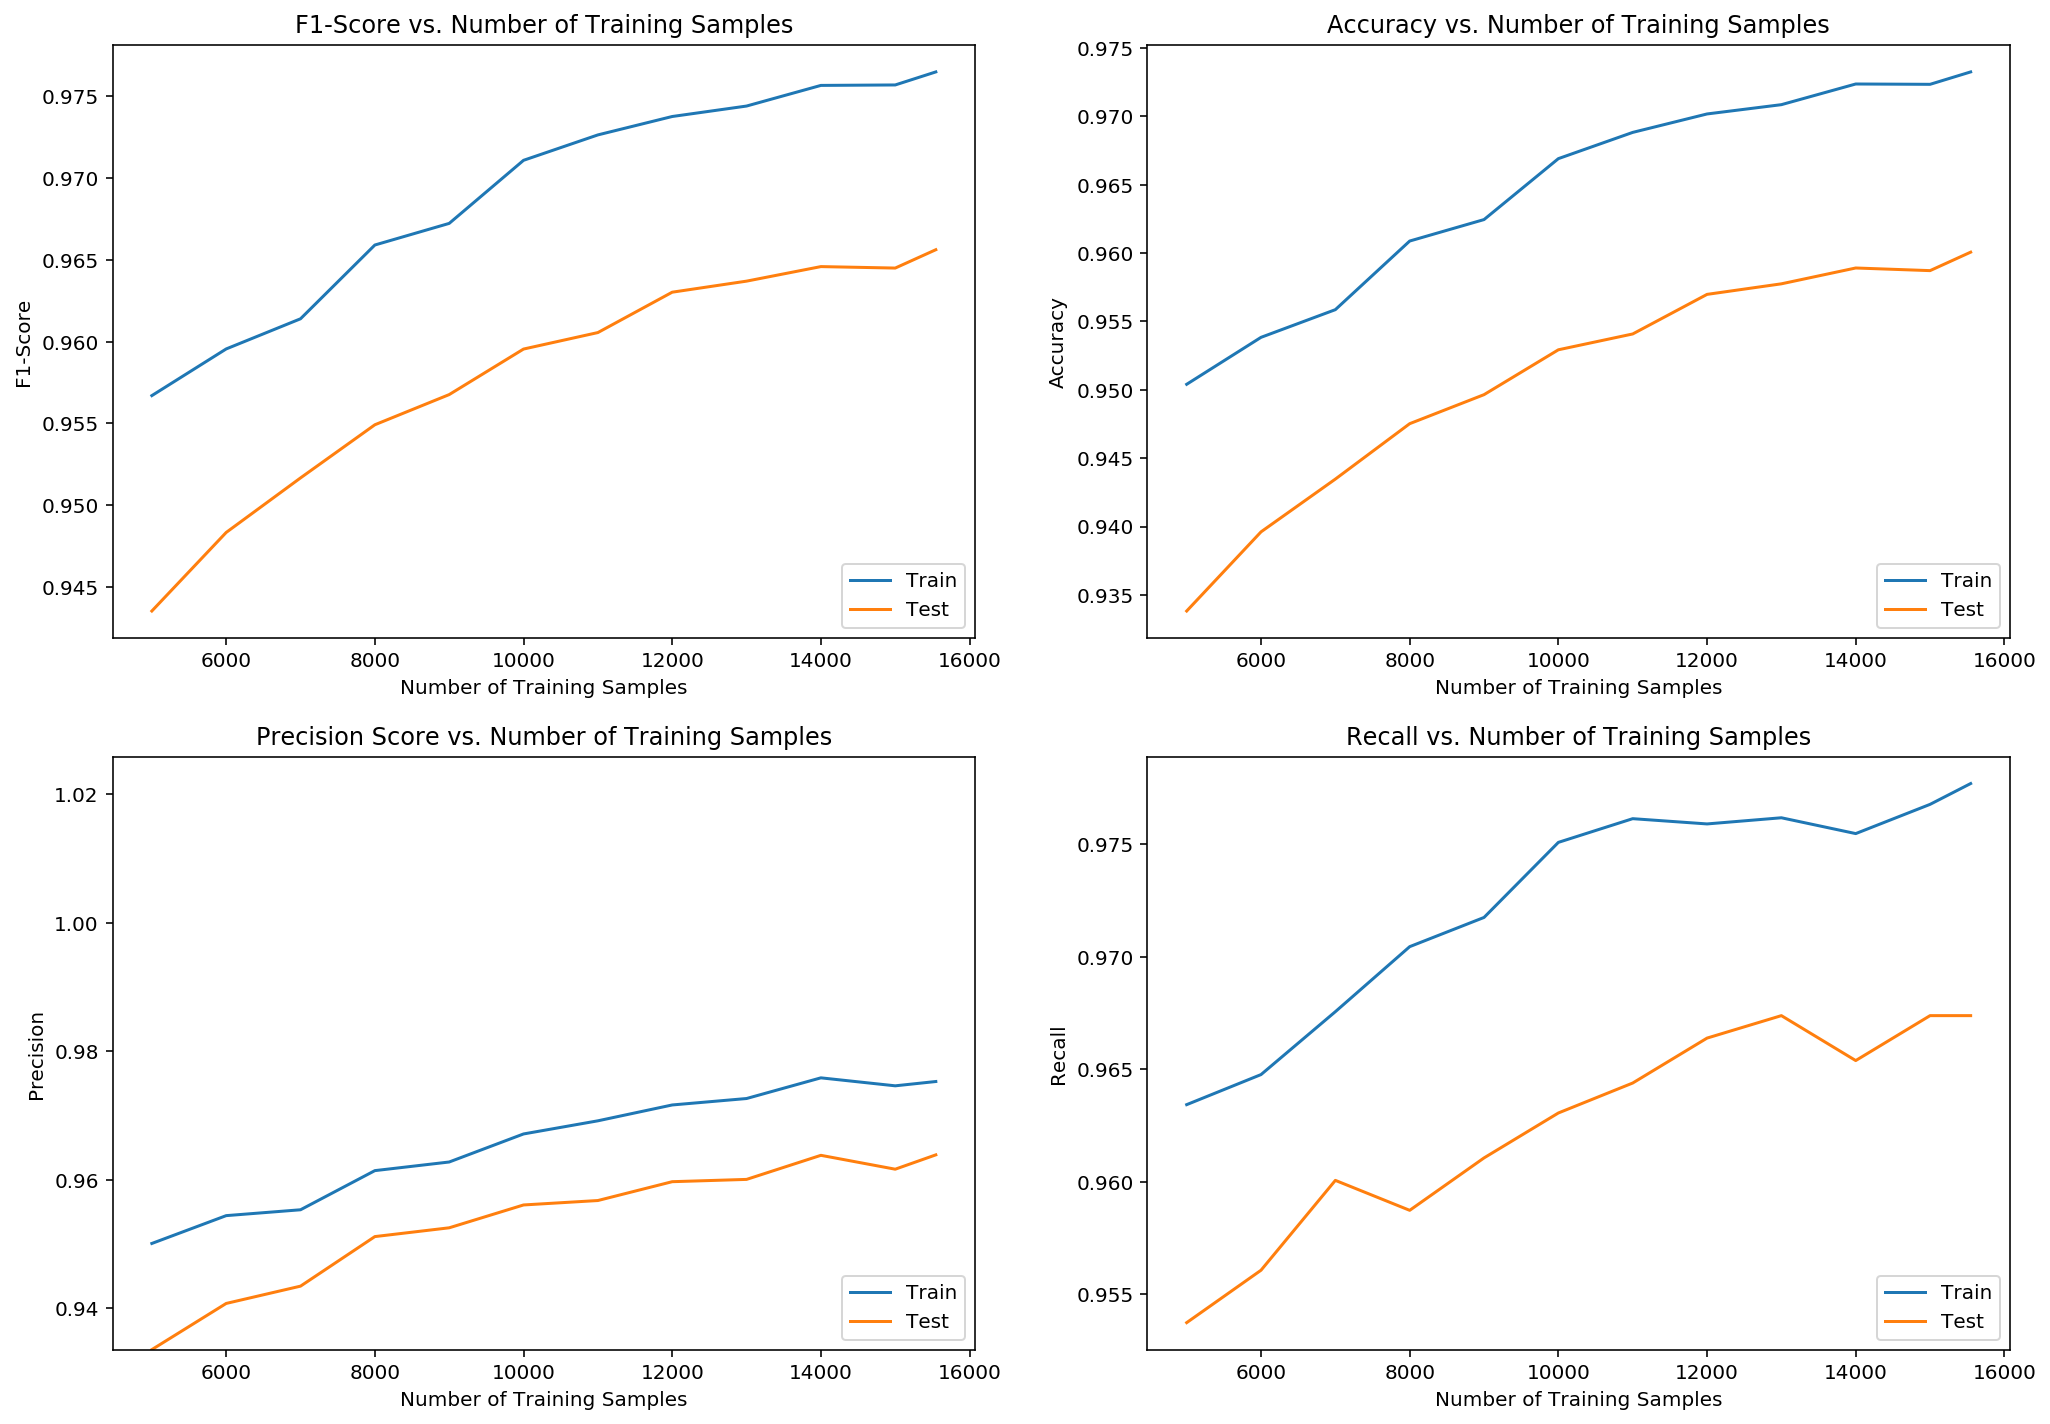

In [37]:
xtrain,xtest,ytrain,ytest = train_test_split(X_body_tfidf,y)

cv = cross_validation(lr_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

In [38]:
lr_reliability = LogisticRegression(penalty='l1')

In [39]:
lr_reliability.fit(X_reliability_train, y_reliability_train)
# get predictions for article section

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
y_reliability_pred = lr_reliability.predict(X_reliability_test)

In [41]:
# print metrics
print ("Logistig Regression F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_reliability_test, y_reliability_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_reliability_test, y_reliability_pred)*100) )

Logistig Regression F1 and Accuracy Scores : 

F1 score 58.16%
Accuracy score 60.97%


# Random Forest
##### Using headlines from the dataset

In [155]:
rcf_headline = RandomForestClassifier(n_estimators=100,n_jobs=3)

In [156]:
rcf_headline.fit(X_headline_tfidf_train, y_headline_train)
y_rc_headline_pred = rcf_headline.predict(X_headline_tfidf_test)

In [157]:
# X_input_headline_tfidf = tfidf.transform(input_headline_tfidf)
# input_body_tfidf = tfidf.fit_transform(input_body_text)
input_headline_tfidf = tfidf.transform(input_headline_text)
input_headline_pred = rcf_headline.predict(input_headline_tfidf)
print (input_headline_pred)

[1]


In [40]:
# print metrics
print ("Random Forest F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_headline_test, y_rc_headline_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_headline_test, y_rc_headline_pred)*100) )

Random Forest F1 and Accuracy Scores : 

F1 score 67.34%
Accuracy score 71.68%


In [41]:
cros_val_list = cross_val_score(rcf_headline, X_headline_tfidf,y,cv=5)
print (cros_val_list)
print (cros_val_list.mean())

[ 0.68861553  0.71900627  0.71659431  0.70646406  0.74209891]
0.714555817603


### Learning Curve for headline random forest

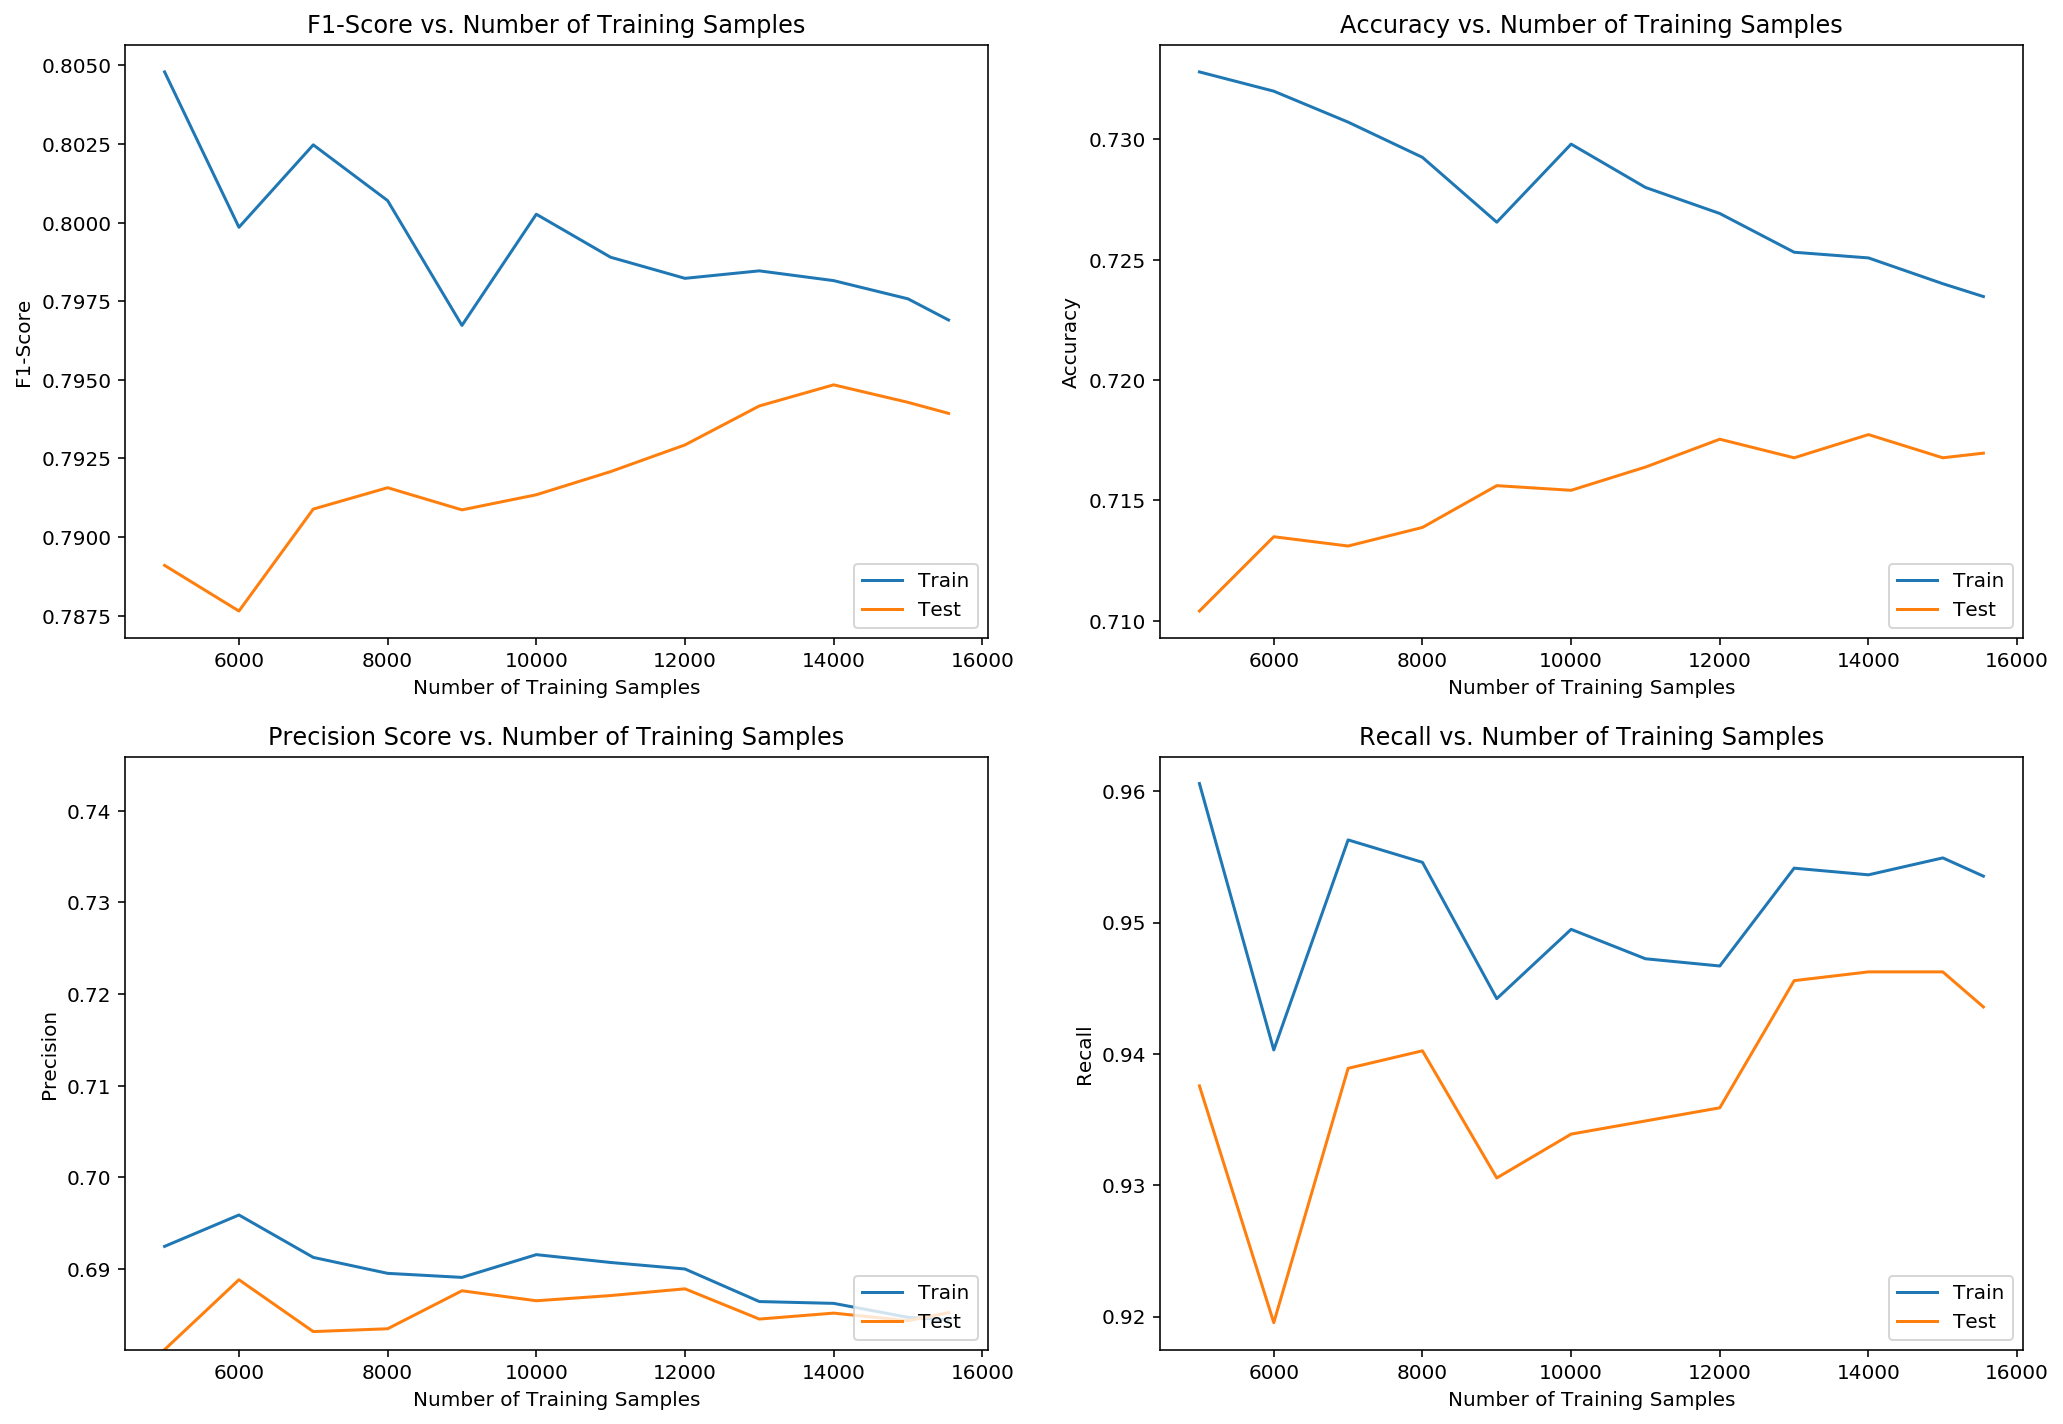

In [42]:
xtrain,xtest,ytrain,ytest = train_test_split(X_headline_tfidf,y)

cv = cross_validation(rcf_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

# Random Forest
##### Using body from the dataset

In [42]:
rcf_body = RandomForestClassifier(n_estimators=100,n_jobs=3)

In [43]:
rcf_body.fit(X_body_tfidf_train, y_body_train)
y_rc_body_pred = rcf_body.predict(X_body_tfidf_test)

In [44]:
input_body_tfidf = tfidf.transform(input_body_text)
input_body_pred = rcf_body.predict(input_body_tfidf)
print (input_body_pred)

ValueError: Number of features of the model must match the input. Model n_features is 5529 and input n_features is 48 

In [45]:
# print metrics
print ("Random Forest F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_body_test, y_rc_body_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_body_test, y_rc_body_pred)*100) )

Random Forest F1 and Accuracy Scores : 

F1 score 98.38%
Accuracy score 98.41%


### Learning Curve for body random forest

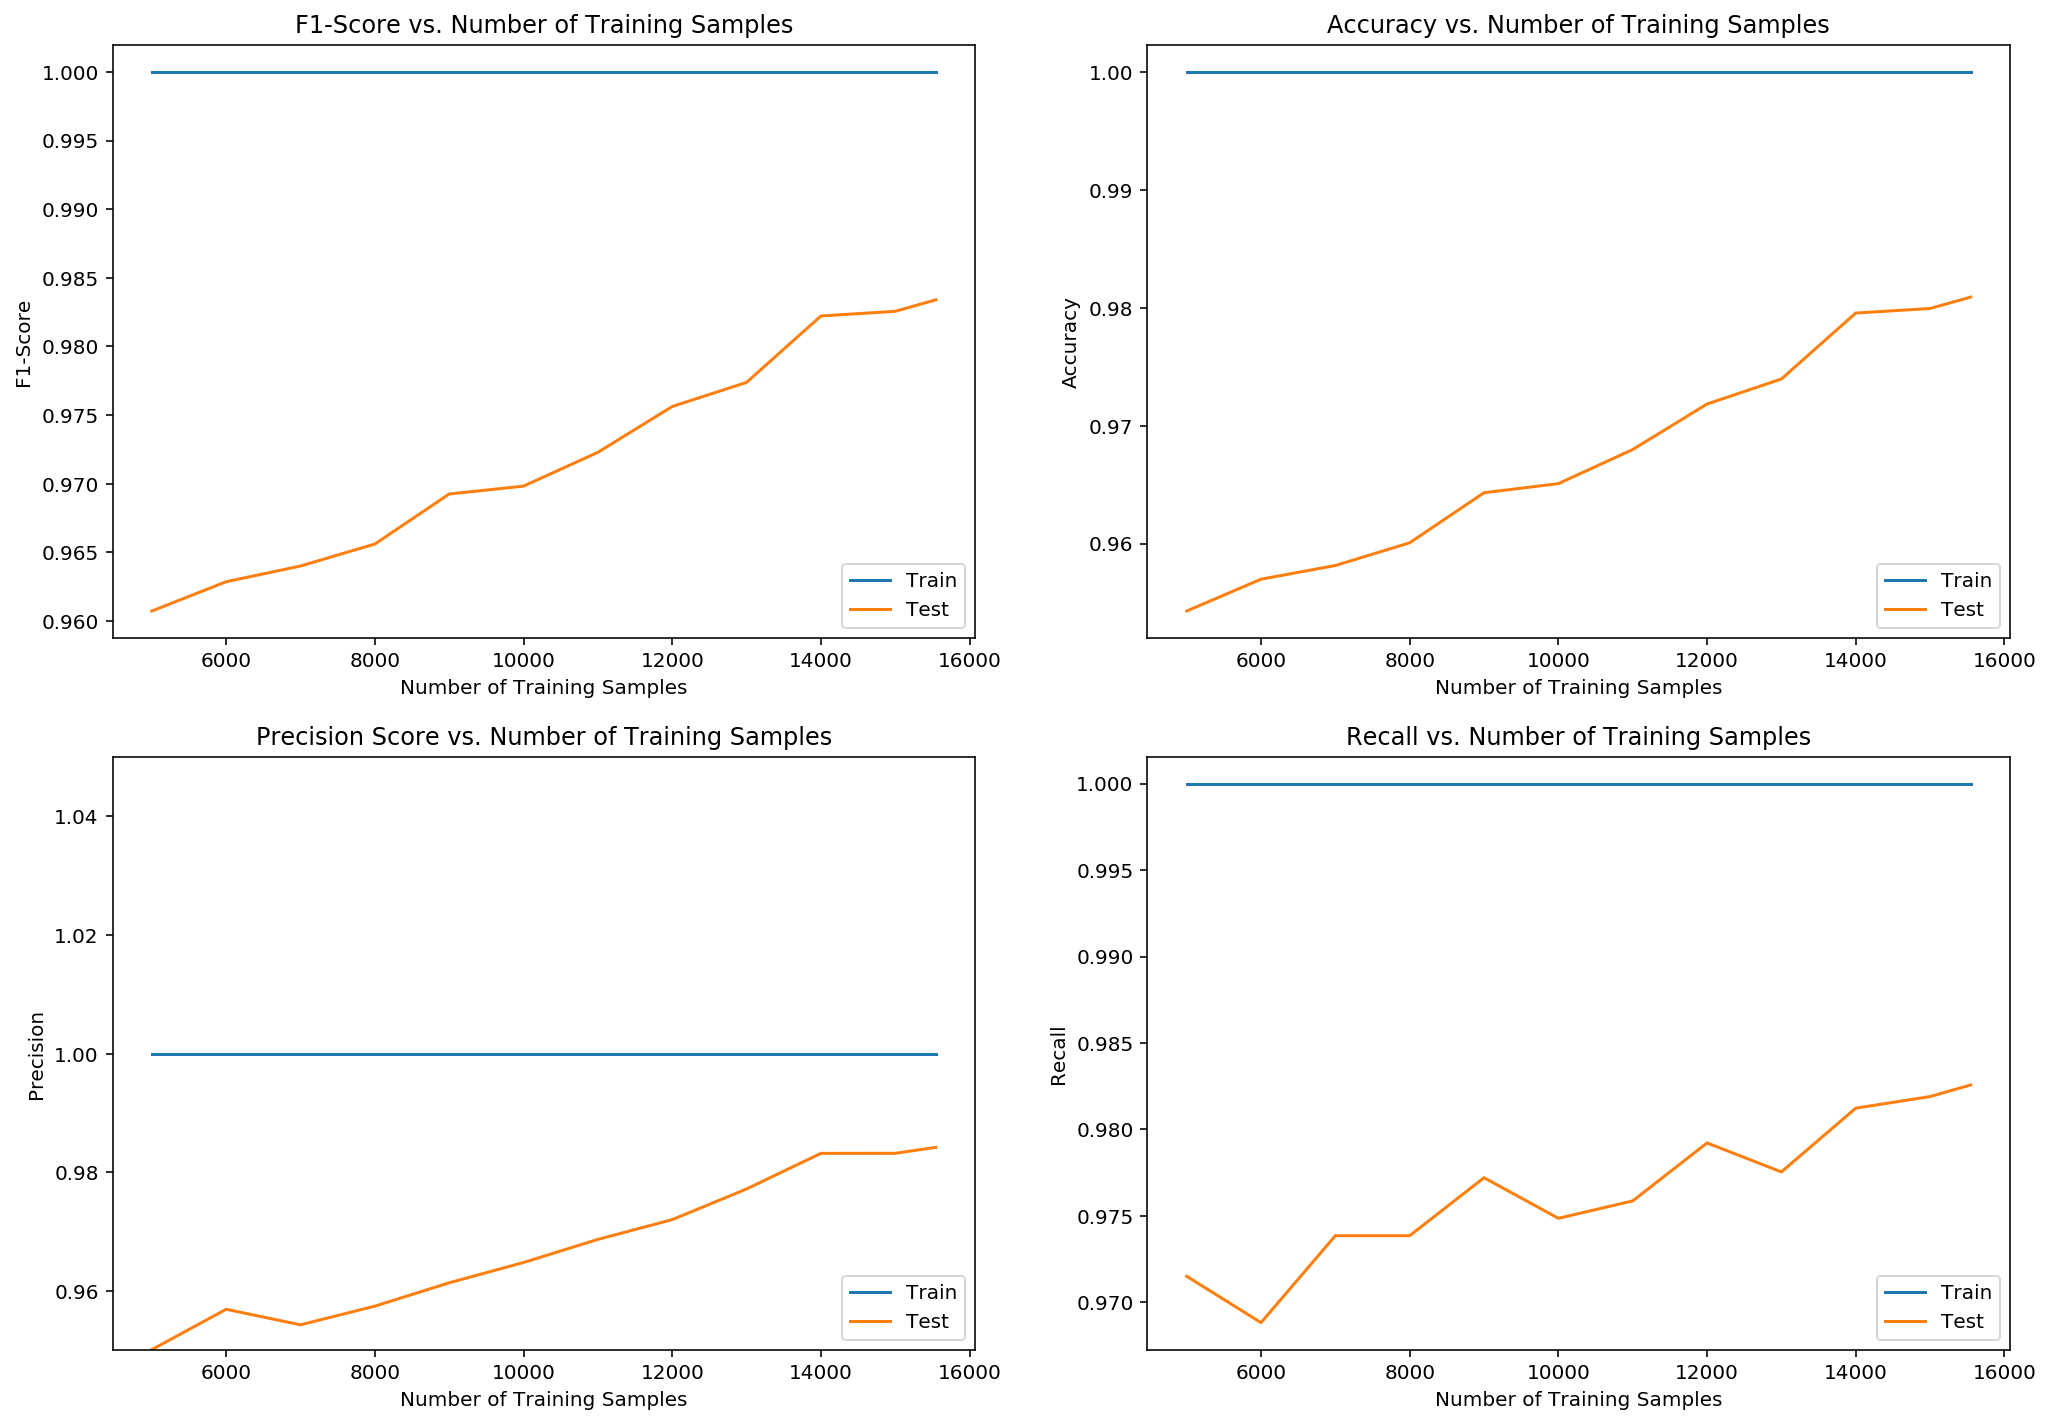

In [46]:
xtrain,xtest,ytrain,ytest = train_test_split(X_body_tfidf,y)

cv = cross_validation(rcf_body, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

# XGBoost Classifier
##### Using headlines from the dataset

In [47]:
xgb_headline = XGBClassifier()

In [48]:
xgb_headline.fit(X_headline_tfidf_train, y_headline_train)
y_xgb_headline_pred = xgb_headline.predict(X_headline_tfidf_test)

In [49]:
# print metrics
print ("XGBoost F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%".format( f1_score(y_headline_test, y_xgb_headline_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_headline_test, y_xgb_headline_pred)*100) )

XGBoost F1 and Accuracy Scores : 

F1 score 64.89%
Accuracy score 70.77%


### Learning Curve for headline XGboost

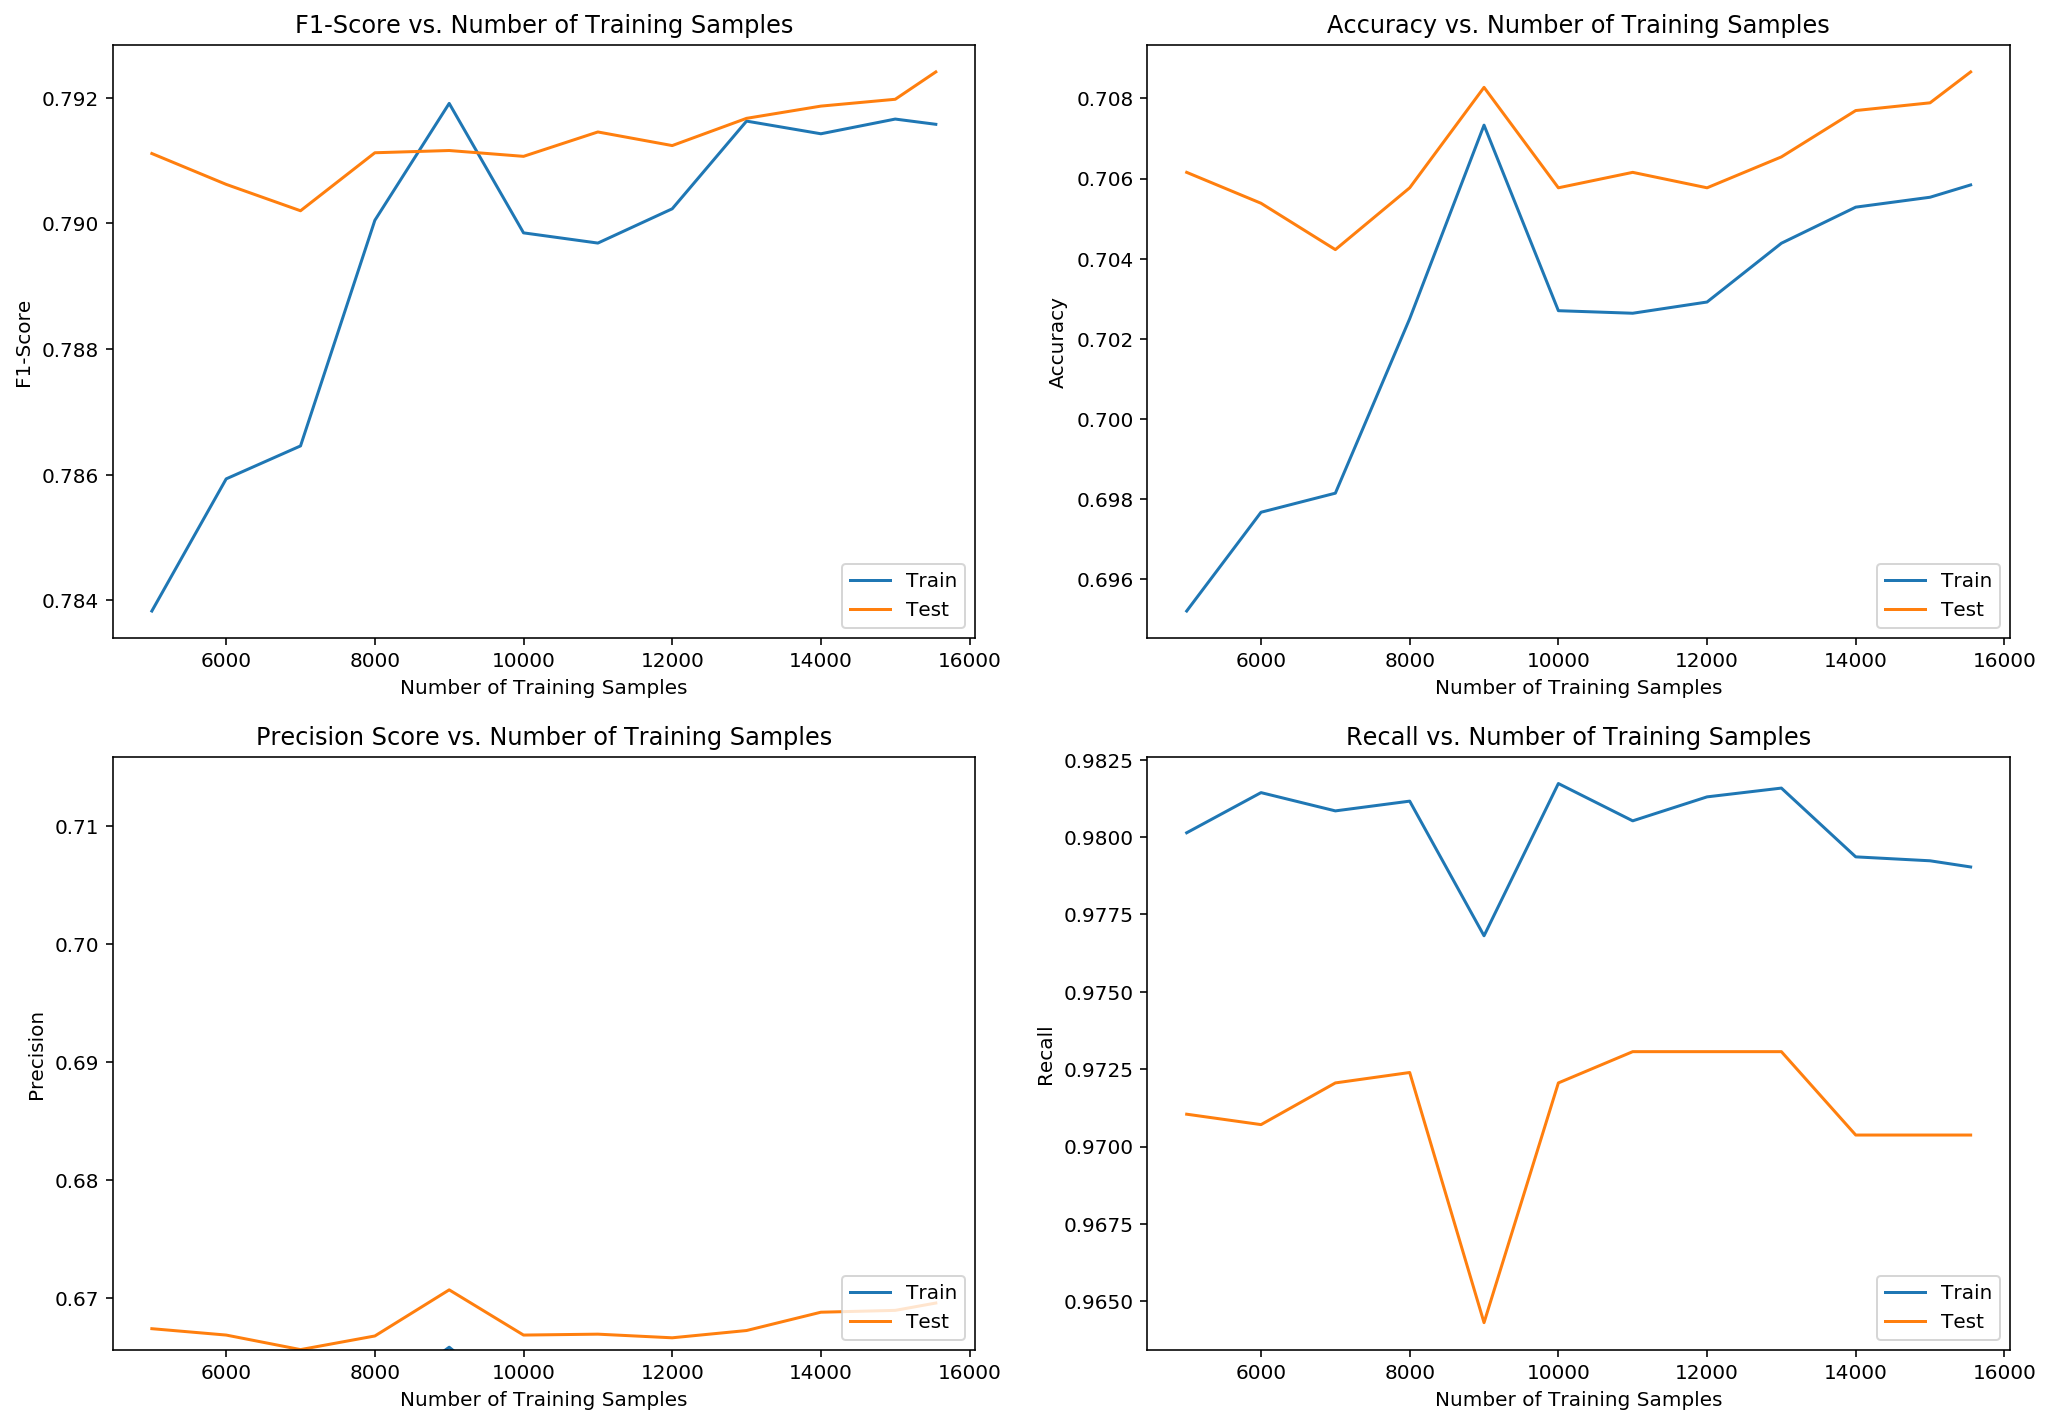

In [50]:
xtrain,xtest,ytrain,ytest = train_test_split(X_headline_tfidf,y)

cv = cross_validation(xgb_headline, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

# XGBoost Classifier
##### Using body from the dataset

In [51]:
xgb_body = XGBClassifier()

In [53]:
xgb_body.fit(X_body_tfidf_train, y_body_train)
y_xgb_body_pred = xgb_body.predict(X_body_tfidf_test)

In [54]:
# print metrics
print ("XGBoost F1 and Accuracy Scores : \n")
print ( "F1 score {:.4}%``".format( f1_score(y_body_test, y_xgb_body_pred, average='macro')*100 ) )
print ( "Accuracy score {:.4}%".format(accuracy_score(y_body_test, y_xgb_body_pred)*100) )

XGBoost F1 and Accuracy Scores : 

F1 score 93.62%``
Accuracy score 93.78%


### Learning Curve for body XGboost

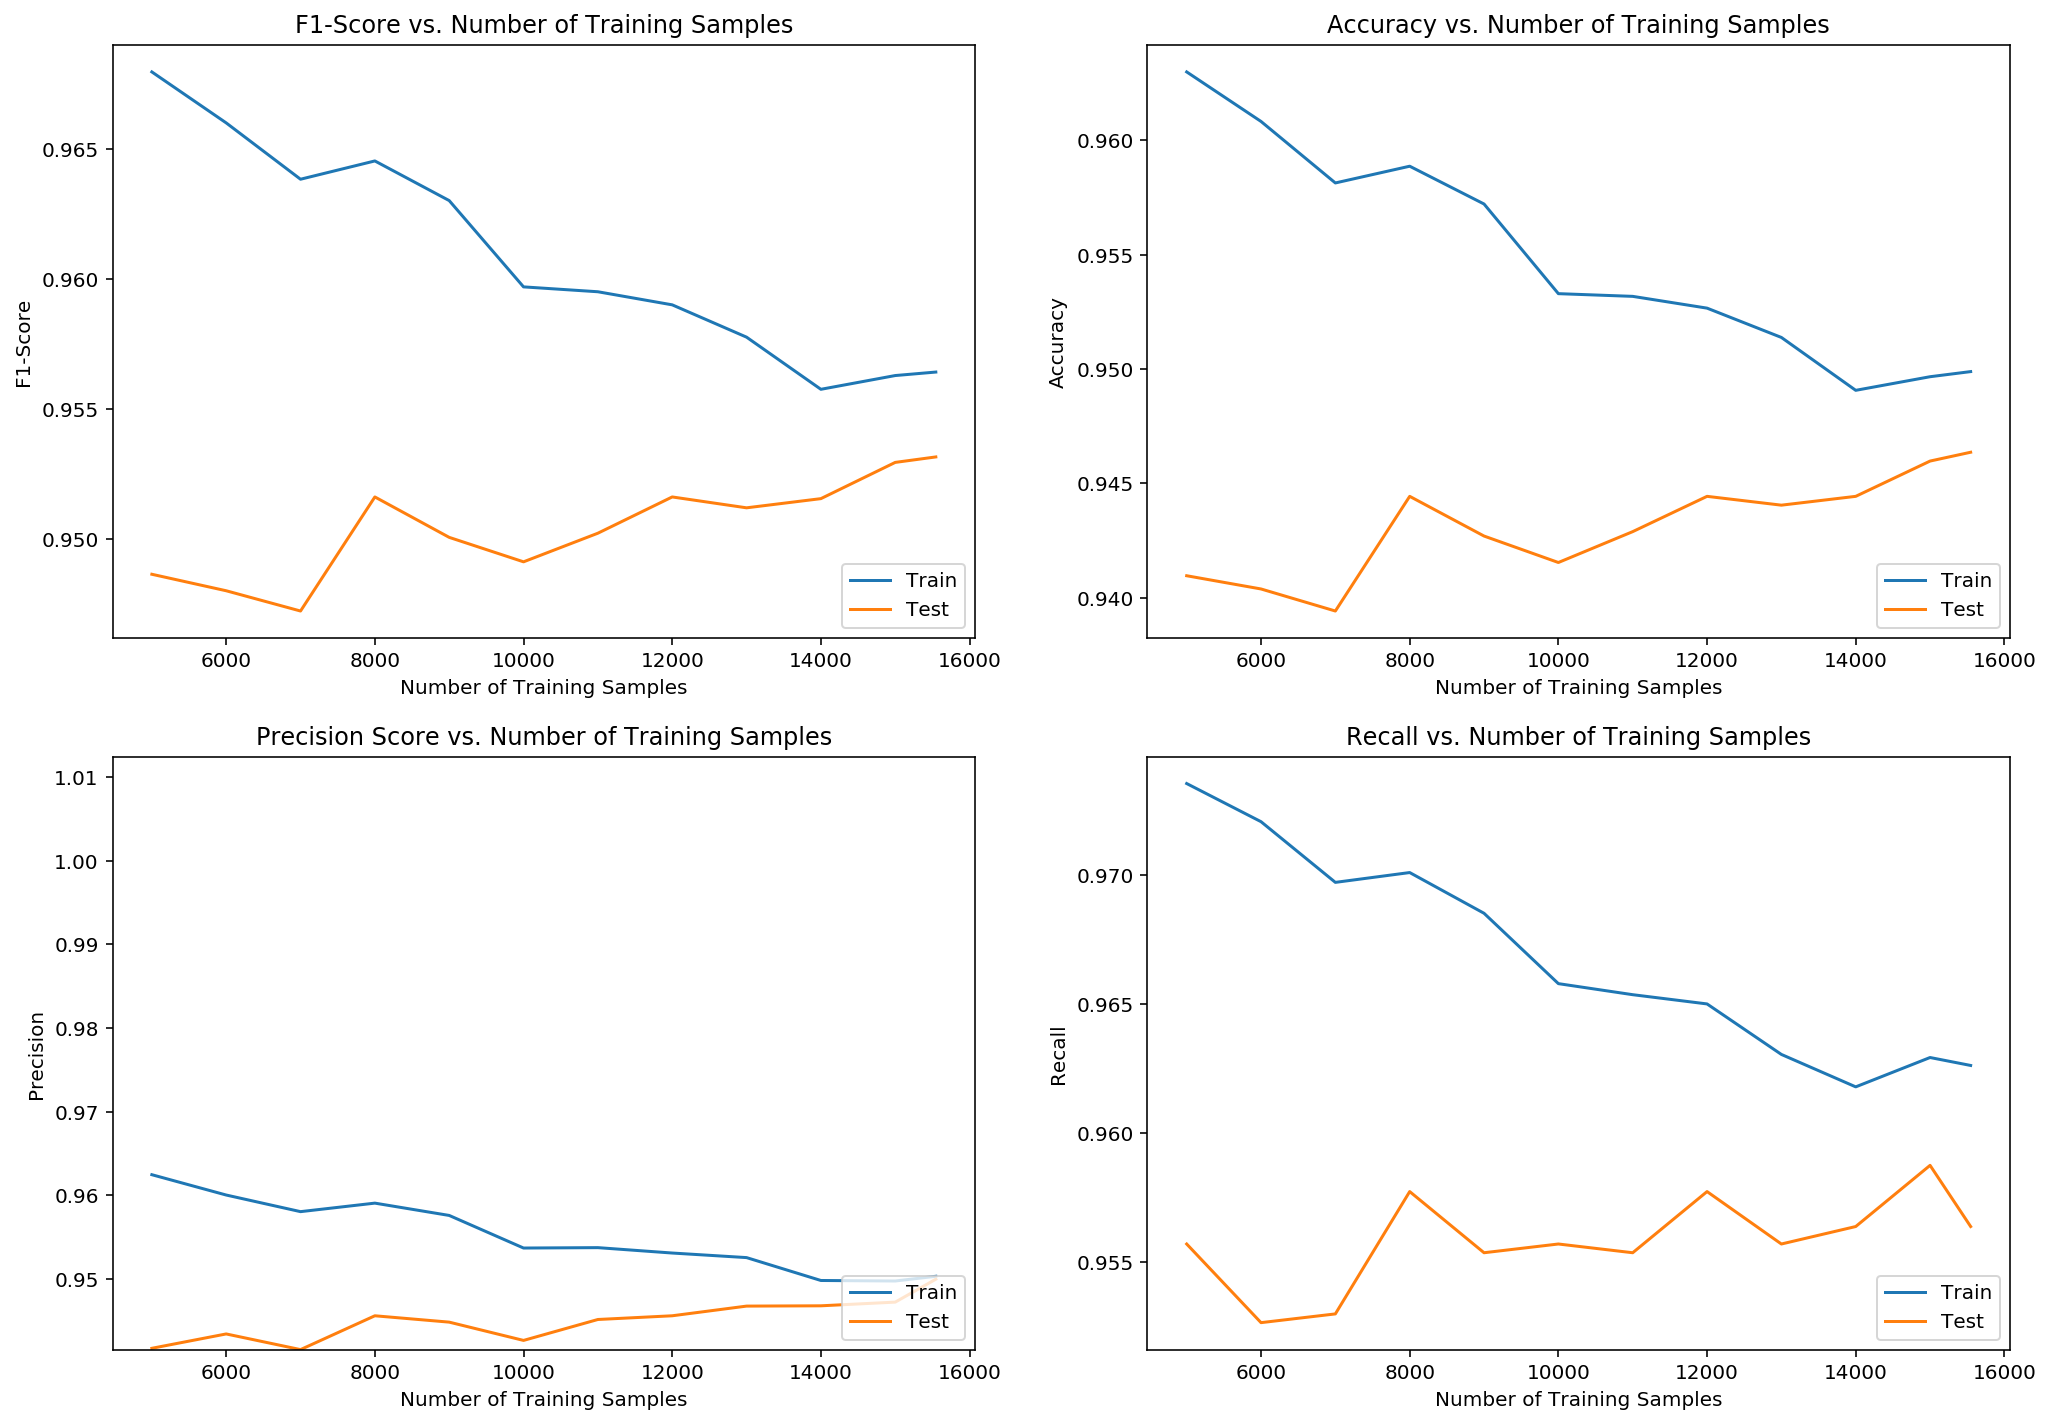

In [55]:
xtrain,xtest,ytrain,ytest = train_test_split(X_body_tfidf,y)

cv = cross_validation(xgb_body, xtrain, ytrain , n_splits=5,init_chunk_size = 5000, chunk_spacings = 1000, average = "binary")
cv.validate_for_holdout_set(xtest, ytest)
cv.plot_learning_curve()

In [7]:
import datetime
from io import StringIO
import random

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from matplotlib.dates import DateFormatter

fig=Figure()
ax=fig.add_subplot(111)
x=[]
y=[]
now=datetime.datetime.now()
delta=datetime.timedelta(days=1)
for i in range(10):
    x.append(now)
    now+=delta
    y.append(random.randint(0, 1000))
ax.plot_date(x, y, '-')
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()
canvas=FigureCanvas(fig)
png_output = StringIO()
#canvas.print_png(png_output)
response=make_response(png_output.getvalue())
response.headers['Content-Type'] = 'image/png'

NameError: name 'make_response' is not defined